# Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r sample_data

In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 14.4 MB/s 


# Import

In [ ]:
import torch
import timm
import pandas as pd
import os
import cv2
import numpy as np

print("torch_version: " + torch.__version__)
print("timm_version: " + timm.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

torch_version: 1.10.0+cu111
timm_version: 0.5.4


('1.10.0+cu111', 'cpu')

# Load dataset

In [ ]:
PATH = "/content/drive/MyDrive/ISIC/2016"
os.listdir(PATH)

['ISBI2016_ISIC_Part3_Training_Data.zip',
 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Test_Data.zip',
 'ISBI2016_ISIC_Part3_Test_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Training_Data',
 'ISBI2016_ISIC_Part3_Test_Data']

In [ ]:
train_path = f'{PATH}/ISBI2016_ISIC_Part3_Training_Data/'
test_path = f'{PATH}/ISBI2016_ISIC_Part3_Test_Data/'

train_csv = f'{PATH}/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
test_csv = f'{PATH}/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'

header_list = ['image_name','benign_malignant']
train = pd.read_csv(train_csv, names=header_list, index_col=False)
train

header_list = ['image_name','target']
test = pd.read_csv(test_csv, names=header_list, index_col=False)
test

,image_name,target
0,ISIC_0000003,0.0
1,ISIC_0000012,0.0
2,ISIC_0000013,1.0
3,ISIC_0000014,0.0
4,ISIC_0000015,0.0
...,...,...
374,ISIC_0011367,0.0
375,ISIC_0011374,1.0
376,ISIC_0011384,0.0
377,ISIC_0011386,0.0


In [ ]:
def to_int(label):
  if label == "benign":
    return 0.0
  elif label == "malignant":
    return 1.0

def to_path_train(image_name):
  return train_path +image_name+'.jpg'

def to_path_test(image_name):
  return test_path +image_name+'.jpg'
train['target'] = train.benign_malignant.apply(to_int)
train['path'] = train.image_name.apply(to_path_train)

test['path'] = test.image_name.apply(to_path_test)
test

,image_name,target,path
0,ISIC_0000003,0.0,/content/drive/MyDrive/ISIC/2016/ISBI2016_ISIC...
1,ISIC_0000012,0.0,/content/drive/MyDrive/ISIC/2016/ISBI2016_ISIC...
2,ISIC_0000013,1.0,/content/drive/MyDrive/ISIC/2016/ISBI2016_ISIC...
3,ISIC_0000014,0.0,/content/drive/MyDrive/ISIC/2016/ISBI2016_ISIC...
4,ISIC_0000015,0.0,/content/drive/MyDrive/ISIC/2016/ISBI2016_ISIC...
...,...,...,...
374,ISIC_0011367,0.0,/content/drive/MyDrive/ISIC/2016/ISBI2016_ISIC...
375,ISIC_0011374,1.0,/content/drive/MyDrive/ISIC/2016/ISBI2016_ISIC...
376,ISIC_0011384,0.0,/content/drive/MyDrive/ISIC/2016/ISBI2016_ISIC...
377,ISIC_0011386,0.0,/content/drive/MyDrive/ISIC/2016/ISBI2016_ISIC...


In [ ]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train, random_state=42, test_size=0.33, shuffle=True, stratify=train['target'])

train_split.shape, val_split.shape
train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)

In [ ]:
from torch.utils.data import Dataset
from skimage import io
from skimage.transform import resize

class MelanomaDataset(Dataset):
  def __init__(self, images, labels=None, train=True):
    self.images = images
    self.labels = labels
    self.train = train

  def load_img(self, img):
    im = io.imread(img)
    return resize(im,(224,224))

  def __getitem__(self, ix):
    img = self.load_img(self.images[ix])
    img = img.transpose(2, 0, 1)
    image = torch.from_numpy(img).float()
    if self.train:
      target = torch.tensor([self.labels[ix]]).float()
      return image, target
    return image
        
  def __len__(self) -> int:
    return len(self.images)

In [ ]:
from torch.utils.data import DataLoader
dataset = {
    'train': MelanomaDataset(train_split['path'], train_split['target']),
    'val': MelanomaDataset(val_split['path'], val_split['target'])
}

In [ ]:
BATCH=32
train_loader = DataLoader(dataset['train'], batch_size=BATCH, shuffle=True)
val_loader = DataLoader(dataset['val'], batch_size=BATCH)

In [ ]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1]))

# Show batch

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

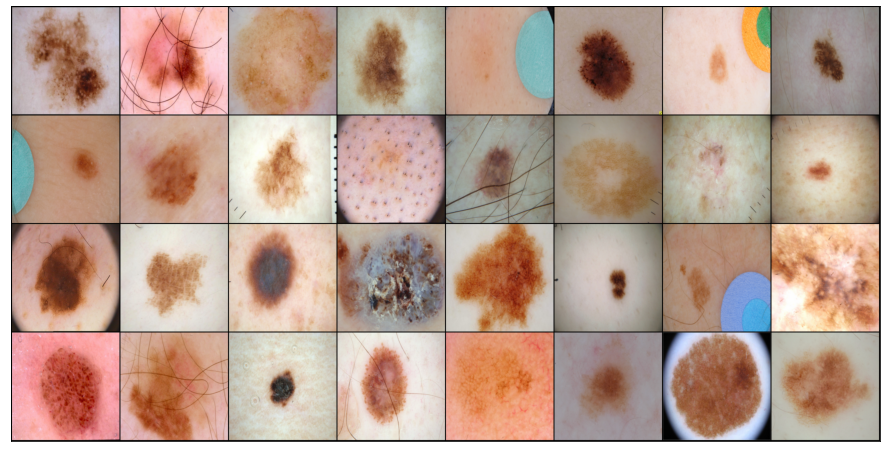

In [ ]:
show_batch(train_loader)

# Model

In [ ]:
import timm
import torch.nn as nn
class MelanomaClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, n_class)
        # self.model.fc = nn.Linear(in_features=net.fc.in_features, out_features=2, bias=True)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = MelanomaClassifier('resnet101',1,True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet101_a1h-36d3f2aa.pth" to /root/.cache/torch/hub/checkpoints/resnet101_a1h-36d3f2aa.pth


In [ ]:
from timm.optim import AdamP
optimizer = AdamP(model.parameters(), lr=0.001)

In [ ]:
from timm.scheduler.plateau_lr import PlateauLRScheduler
scheduler = PlateauLRScheduler(
        optimizer,
        patience_t=3,
        threshold=0.001,
        mode="max"
    )

In [ ]:
import timm.loss
loss_criterion = torch.nn.BCEWithLogitsLoss()

# Train

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

def auc_score(outputs, targets):
    outputs = torch.sigmoid(outputs)
    outputs = outputs.numpy()
    targets = targets.numpy()
    auc = roc_auc_score(targets, outputs)
    return auc

def f1_score(outputs, targets):
    outputs = torch.sigmoid(outputs)
    outputs = outputs.numpy()
    targets = targets.numpy()
    f1 = f1_score(targets, outputs)
    return f1

In [ ]:
from fastprogress import master_bar, progress_bar
model.to(DEVICE)

num_epochs = 10
mb = master_bar(range(1,num_epochs+1))

val_steps=2
best_auc = 0

count=0
count_2=0
for epoch in mb:
  #training phase
  model.train()
  train_losses = []
  for batch in progress_bar(train_loader, parent=mb):
    # count+=1
    inputs, targets = batch
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    outputs = model(inputs)
    loss = loss_criterion(outputs, targets)
    loss.backward()
    train_losses.append(loss)
    optimizer.step()
    optimizer.zero_grad()
    train_loss = torch.stack(train_losses).mean().item()
    mb.child.comment = f'loss {train_loss:.5f}'
    if count>val_steps:
      break
        
        
  # train_loss = torch.stack(train_losses).mean().item()
  #Validation
  model.eval()
  val_losses=[]

  # AUC may have conflicts if the batch does not have two targets
  val_outputs = torch.tensor([])
  val_targets = torch.tensor([])

  with torch.no_grad():
    for batch in progress_bar(val_loader, parent=mb):
      inputs, targets = batch
      inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
      outputs = model(inputs)
      loss = loss_criterion(outputs, targets)
      val_losses.append(loss)
      optimizer.step()
      optimizer.zero_grad()
      # count_2+=1

      # handle AUC fix
      val_outputs = torch.cat([val_outputs, outputs.cpu()])
      val_targets = torch.cat([val_targets, targets.cpu()])
    
      val_loss = torch.stack(val_losses).mean().item()
      mb.child.comment = f'val_loss {val_loss:.5f}'
      if count_2>val_steps:
        break
    auc = auc_score(val_outputs, val_targets)
    if auc > best_auc:
      best_auc = auc
      # torch.save(model, f'{PATH}/model.pth')
      torch.save(model, 'model.pth')
      print(f"Current best model: {auc:.5f}")
    print("Epoch [{}] -> train_loss: {:.4f}, val_loss: {:.4f}, val_auc: {:.4f}".format(epoch, train_loss, val_loss, auc))
  

Current best model: 0.54335
Epoch [1] -> train_loss: 0.5125, val_loss: 0.5351, val_auc: 0.5433
Current best model: 0.71213
Epoch [2] -> train_loss: 0.4470, val_loss: 0.4681, val_auc: 0.7121


Current best model: 0.74386
Epoch [3] -> train_loss: 0.2950, val_loss: 0.7074, val_auc: 0.7439
Epoch [4] -> train_loss: 0.2222, val_loss: 0.5013, val_auc: 0.6908
Epoch [5] -> train_loss: 0.2005, val_loss: 0.6898, val_auc: 0.7205
Epoch [6] -> train_loss: 0.2254, val_loss: 0.5493, val_auc: 0.7394
Epoch [7] -> train_loss: 0.1872, val_loss: 0.9667, val_auc: 0.7149
Current best model: 0.75110
Epoch [8] -> train_loss: 0.1275, val_loss: 0.6393, val_auc: 0.7511
Epoch [9] -> train_loss: 0.0929, val_loss: 0.7151, val_auc: 0.7211
Current best model: 0.77376
Epoch [10] -> train_loss: 0.0867, val_loss: 0.6863, val_auc: 0.7738


# Test

In [ ]:
test_dataset = MelanomaDataset(test['path'], test['target'])

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
images, labels = next(iter(test_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1]))

In [ ]:
model = torch.load('model.pth',map_location=torch.device('cpu'))
model.to(DEVICE)
model.eval()
preds = torch.tensor([]).to(DEVICE)
val_outputs = torch.tensor([])
val_targets = torch.tensor([])
with torch.no_grad():
  for batch in progress_bar(test_loader):
    imgs, targets = batch
    imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
    outputs = model(imgs)
    preds = torch.cat([preds, outputs.view(-1)])

    val_outputs = torch.cat([val_outputs, outputs.cpu()])
    val_targets = torch.cat([val_targets, targets.cpu()])
  auc = auc_score(val_outputs, val_targets)
  print("auc:",auc)

auc: 0.6785526315789474


# Submission

In [ ]:
submission = pd.DataFrame({'image_name': test['image_name'].values, 'target': preds.cpu().numpy()})

In [ ]:
submission.to_csv('submission.csv', index=False)